## ADA501 - Prosjekt

In [192]:
# !pip install numpy_financial

In [193]:
import pandas as pd
import numpy as np
import sympy as sp
from collections import namedtuple
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import numpy_financial as npf
import matplotlib.pyplot as plt
from collections import namedtuple

In [194]:
k1 = 0.1        # Økning i forbruk etter inntekt                    -> hurtig økning etter inntektsøkning
k2 = 0.7        # Reduksjon i forbruk etter inntekt                 -> sakte endring etter inntektsfall
k3 = 0.3        # Renteendring basert på forbruk                    -> Forbruk øker -> Renter øker  -> Lånet påvirkes -> Må bruke mindre penger
k4 = 0.025       # Endring i inflasjon basert på forbuk & rente      -> Endres 0,25 poeng oftest

In [195]:
I0 = 10000      # Startinntekt pr måend
U0 = 6000       # Faste utgifter
F0 = 5000       # Initiale forbruksvaner
R0 = 0.05       # Startboliglånsrenterente
S0 = 0          # Ønsker å starte med 0 kr i overskudd, men fast inntekt
S0 = 300000     # Startsluttresultat over 25 år, vil ha et overskudd på konto

In [196]:
t0 = 0
t1 = 25

# Definer tidsintervall og initialverdier
t_span = (t0, t1)
y0 = [I0, U0, F0, R0]

## les inn csv filer

In [197]:
df = pd.read_excel('Siste.xlsx')

In [198]:
# Filter 'Inntekt'
inntekt = df[df['Hva'] == 'Inntekt']
inntekt = inntekt.drop('Hva', axis=1)
# Filter 'Faste utgifter'
faste_utgifter = df[df['Hva'] == 'Faste utgifter']
faste_utgifter = faste_utgifter.drop('Hva', axis=1)
# Filter 'Luksus'
forbruk = df[df['Hva'] == 'Luksus']
forbruk=forbruk.drop('Hva' , axis=1)

In [199]:
inntekt

,Dato,Brukt
3,2020-01-03,128
5,2020-01-03,128
6,2020-01-03,128
7,2020-01-03,130
8,2020-01-06,100
...,...,...
1093,2023-09-18,60
1094,2023-09-18,"615,87"
1097,2023-10-10,105
1098,2023-10-12,"9402,74"


## Funksjonene

Inntekt

In [200]:
inntekt['Brukt'] = inntekt['Brukt'].str.replace(',', '.')
inntekt['Brukt'] = inntekt['Brukt'].astype(float)


In [201]:
inntekt['Dato'] = pd.to_datetime(inntekt['Dato'])
X = (inntekt['Dato'] - inntekt['Dato'].min()).dt.days.values.reshape(-1, 1)
y = inntekt['Brukt'].values
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

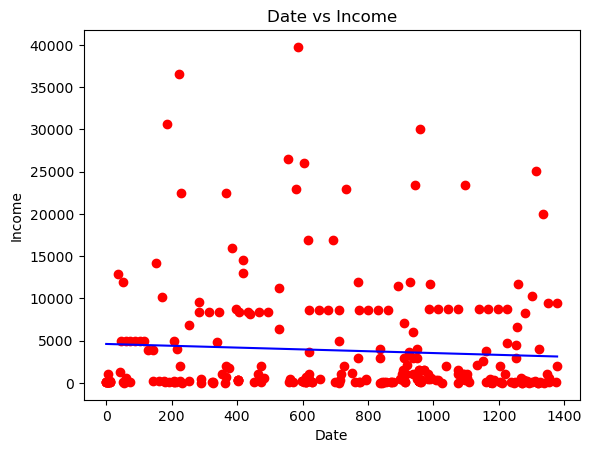

In [202]:
y_pred = regressor.predict(X)

import matplotlib.pyplot as plt
plt.scatter(X, y, color='red')
plt.plot(X, regressor.predict(X), color='blue')
plt.title('Date vs Income')
plt.xlabel('Date')
plt.ylabel('Income')
plt.show()

Små feil for income og dato

Faste utgifter

In [203]:
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].str.replace(',', '.')
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].astype(float)

In [204]:
faste_utgifter['Dato'] = pd.to_datetime(faste_utgifter['Dato'])
X = (faste_utgifter['Dato'] - faste_utgifter['Dato'].min()).dt.days.values.reshape(-1, 1)
y = faste_utgifter['Brukt'].values
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

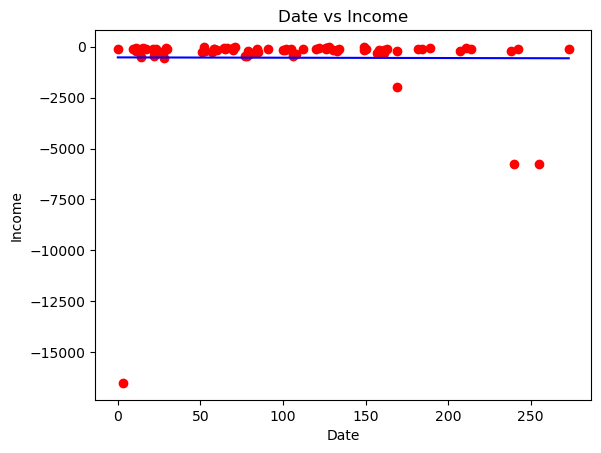

In [205]:
y_pred = regressor.predict(X)

import matplotlib.pyplot as plt
plt.scatter(X, y, color='red')
plt.plot(X, regressor.predict(X), color='blue')
plt.title('Date vs Income')
plt.xlabel('Date')
plt.ylabel('Income')
plt.show()

Feil her også med dato - samme problem som inntekt

Har faste utgifter på 4750 kr i husleie nå

Forbruk

In [206]:
forbruk['Brukt'] = forbruk['Brukt'].str.replace(',', '.')
forbruk['Brukt'] = forbruk['Brukt'].astype(float)

In [207]:
forbruk['Dato'] = pd.to_datetime(forbruk['Dato'])
X = (forbruk['Dato'] - forbruk['Dato'].min()).dt.days.values.reshape(-1, 1)
y = forbruk['Brukt'].values
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

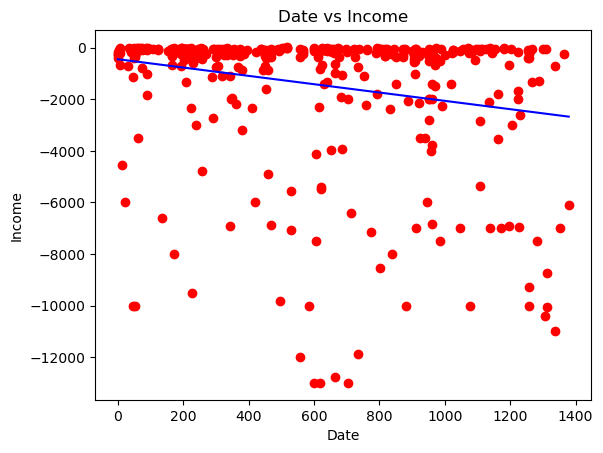

In [208]:
y_pred = regressor.predict(X)

import matplotlib.pyplot as plt
plt.scatter(X, y, color='red')
plt.plot(X, regressor.predict(X), color='blue')
plt.title('Date vs Income')
plt.xlabel('Date')
plt.ylabel('Income')
plt.show()

Feil her også

forbrukets ODE

In [209]:
forbruk['Brukt'] = forbruk['Brukt'].abs()
forbruk = forbruk.groupby('Dato')['Brukt'].sum().reset_index()

In [210]:
def forbruk_model(t, forbruk, inntekt, faste_utgifter, k1, k2):
   d_forbruk_dt = k1 * (inntekt - faste_utgifter) - k2 * forbruk
   return d_forbruk_dt

In [211]:
from scipy.integrate import odeint

forbruk = forbruk.sort_values('Dato')
start_date = forbruk['Dato'].min()
end_date = forbruk['Dato'].max()
t = pd.date_range(start_date, end_date)

# Define the initial conditions and parameters
initial_conditions = F0
parameters = [k1, k2]

# Solve the ODE
solution = odeint(forbruk_model, initial_conditions, t, args=(inntekt, faste_utgifter, *parameters))


UFuncTypeError: Cannot cast ufunc 'greater_equal' input 0 from dtype('<m8[ns]') to dtype('<m8') with casting rule 'same_kind'

In [ ]:
import matplotlib.pyplot as plt

plt.plot(t, solution)
plt.xlabel('Time')
plt.ylabel('Forbruk')
plt.show()

HIT

In [ ]:
def stryingsrente(t, interest_rate, inflation_rate, target_inflation):
    # Define how the interest rate changes based on inflation
    if inflation_rate == target_inflation:
        return 0
    elif inflation_rate > target_inflation:
        return 0.0025  # Increase by 0.25% if inflation is above target
    else:
        return -0.0025  # Decrease by 0.25% if inflation is below target

In [ ]:
def inflasjon(t, inflation, economic_factors, target_rate):
    adjustment = k4 * (economic_factors - target_rate)
    return adjustment

## Ønsket lån

In [ ]:
startKapital = 0    # startkapitalen
terminer = 300      # 12 terminer over 25 år

Serielån

Annuitetslån

In [ ]:
initial_conditions = [I0, F0]  # Initielle betingelser
sol = solve_ivp(inntekt, t_span, initial_conditions, args=(k1, k2))

TypeError: Inntekt() takes 2 positional arguments but 4 were given